<a href="https://colab.research.google.com/github/Sujoy-004/Chat-Analyzer-Pro/blob/main/notebooks/04_relationship_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cell 1 : Setup and Data Preparation

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
from io import StringIO

In [11]:
# Fetch and prepare the data
url = "https://raw.githubusercontent.com/Sujoy-004/Chat-Analyzer-Pro/refs/heads/main/data/processed/example_parsed.csv"
response = requests.get(url)
df = pd.read_csv(StringIO(response.text))

# Convert datetime column to proper datetime type
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)

In [12]:
print(f"Total messages: {len(df)}")
print(f"Date range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Participants: {df['sender'].unique()}")
print(f"Message distribution:")
print(df['sender'].value_counts())

Total messages: 27
Date range: 2023-12-25 09:30:00 to 2023-12-27 08:15:00
Participants: ['Alice' 'Bob']
Message distribution:
sender
Alice    14
Bob      13
Name: count, dtype: int64


In [13]:
# Calculate time differences between consecutive messages
df['time_diff'] = df['datetime'].diff()
df['prev_sender'] = df['sender'].shift(1)

# Identify conversation starters (messages after gaps > 1 hour or different day)
df['is_conversation_starter'] = False

# Mark first message as conversation starter
df.loc[0, 'is_conversation_starter'] = True

In [14]:
# Mark messages as conversation starters if:
# 1. More than 1 hour gap from previous message
# 2. Different sender after a gap > 30 minutes
for i in range(1, len(df)):
    time_gap = df.loc[i, 'time_diff'].total_seconds() / 3600  # hours

    if time_gap > 1:  # More than 1 hour gap
        df.loc[i, 'is_conversation_starter'] = True
    elif time_gap > 0.5 and df.loc[i, 'sender'] != df.loc[i-1, 'sender']:  # 30+ min gap with sender change
        df.loc[i, 'is_conversation_starter'] = True

In [15]:
print(f"\nConversation starters identified: {df['is_conversation_starter'].sum()}")
print("Conversation starters by sender:")
conversation_starters = df[df['is_conversation_starter']==True]['sender'].value_counts()
print(conversation_starters)


Conversation starters identified: 6
Conversation starters by sender:
sender
Alice    3
Bob      3
Name: count, dtype: int64


In [16]:
# Show sample of data with new columns
print("\n=== SAMPLE DATA WITH NEW FEATURES ===")
print(df[['datetime', 'sender', 'message', 'time_diff', 'is_conversation_starter']].head(10).to_string())


=== SAMPLE DATA WITH NEW FEATURES ===
             datetime sender                                                                    message       time_diff  is_conversation_starter
0 2023-12-25 09:30:00  Alice                                                        Merry Christmas! 🎄🎅             NaT                     True
1 2023-12-25 09:32:00    Bob                 Merry Christmas to you too! Hope you're having a great day 0 days 00:02:00                    False
2 2023-12-25 09:35:00  Alice  Thanks! Opening presents with family right now Family time is the best ❤️ 0 days 00:03:00                    False
3 2023-12-25 10:15:00    Bob               That sounds wonderful! I'm cooking dinner for everyone today 0 days 00:40:00                     True
4 2023-12-25 10:16:00  Alice                                                            <Media omitted> 0 days 00:01:00                    False
5 2023-12-25 10:17:00  Alice                                                 Here's our Chr

## Cell 2 : Initiator Ratio Analysis

In [17]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Calculate time differences
df['time_diff'] = df['datetime'].diff()
df['time_diff_minutes'] = df['time_diff'].dt.total_seconds() / 60
df['prev_sender'] = df['sender'].shift(1)

In [19]:
# Show all messages with time gaps
for i, row in df.iterrows():
    time_gap = f"{row['time_diff_minutes']:.0f} min" if pd.notna(row['time_diff_minutes']) else "START"
    prev_sender = row['prev_sender'] if pd.notna(row['prev_sender']) else "None"

    print(f"{i:2d}. {row['datetime']} | {row['sender']:5s} | Gap: {time_gap:8s} | Prev: {prev_sender:5s} | {row['message'][:50]}...")

 0. 2023-12-25 09:30:00 | Alice | Gap: START    | Prev: None  | Merry Christmas! 🎄🎅...
 1. 2023-12-25 09:32:00 | Bob   | Gap: 2 min    | Prev: Alice | Merry Christmas to you too! Hope you're having a g...
 2. 2023-12-25 09:35:00 | Alice | Gap: 3 min    | Prev: Bob   | Thanks! Opening presents with family right now Fam...
 3. 2023-12-25 10:15:00 | Bob   | Gap: 40 min   | Prev: Alice | That sounds wonderful! I'm cooking dinner for ever...
 4. 2023-12-25 10:16:00 | Alice | Gap: 1 min    | Prev: Bob   | <Media omitted>...
 5. 2023-12-25 10:17:00 | Alice | Gap: 1 min    | Prev: Alice | Here's our Christmas tree!...
 6. 2023-12-25 11:30:00 | Bob   | Gap: 73 min   | Prev: Alice | Beautiful tree! 😍 Our dinner is almost ready...
 7. 2023-12-25 11:45:00 | Alice | Gap: 15 min   | Prev: Bob   | Can't wait to see photos!...
 8. 2023-12-25 14:30:00 | Bob   | Gap: 165 min  | Prev: Alice | <Media omitted>...
 9. 2023-12-25 14:31:00 | Bob   | Gap: 1 min    | Prev: Bob   | Christmas dinner success! 🍽️..

In [20]:
# Reset conversation starter detection
df['is_conversation_starter'] = False

# Rule 1: First message is always a conversation starter
df.loc[0, 'is_conversation_starter'] = True
print(f"Message 0: First message - STARTER")

# Rule 2: Messages with gaps > 60 minutes OR new day
for i in range(1, len(df)):
    current_time = df.loc[i, 'datetime']
    prev_time = df.loc[i-1, 'datetime']
    time_gap_minutes = (current_time - prev_time).total_seconds() / 60
    different_day = current_time.date() != prev_time.date()

    if time_gap_minutes > 60 or different_day:
        df.loc[i, 'is_conversation_starter'] = True
        reason = "New Day" if different_day else f"Gap: {time_gap_minutes:.0f} min"
        print(f"Message {i}: {reason} - STARTER")

Message 0: First message - STARTER
Message 6: Gap: 73 min - STARTER
Message 8: Gap: 165 min - STARTER
Message 13: New Day - STARTER
Message 21: New Day - STARTER


In [22]:
starters_df = df[df['is_conversation_starter']==True][['datetime', 'sender', 'message', 'time_diff_minutes']]
print(starters_df.to_string())

              datetime sender                                       message  time_diff_minutes
0  2023-12-25 09:30:00  Alice                           Merry Christmas! 🎄🎅                NaN
6  2023-12-25 11:30:00    Bob  Beautiful tree! 😍 Our dinner is almost ready               73.0
8  2023-12-25 14:30:00    Bob                               <Media omitted>              165.0
13 2023-12-26 08:00:00  Alice           Good morning! How was your evening?             1005.0
21 2023-12-27 07:00:00  Alice      Happy Wednesday! Back to reality today 😅             1245.0


In [23]:
total_starters = df['is_conversation_starter'].sum()
starter_counts = df[df['is_conversation_starter']==True]['sender'].value_counts()

print(f"Total conversation starters: {total_starters}")
for sender, count in starter_counts.items():
    percentage = (count / total_starters) * 100
    print(f"  {sender}: {count} conversations ({percentage:.1f}%)")

Total conversation starters: 5
  Alice: 3 conversations (60.0%)
  Bob: 2 conversations (40.0%)


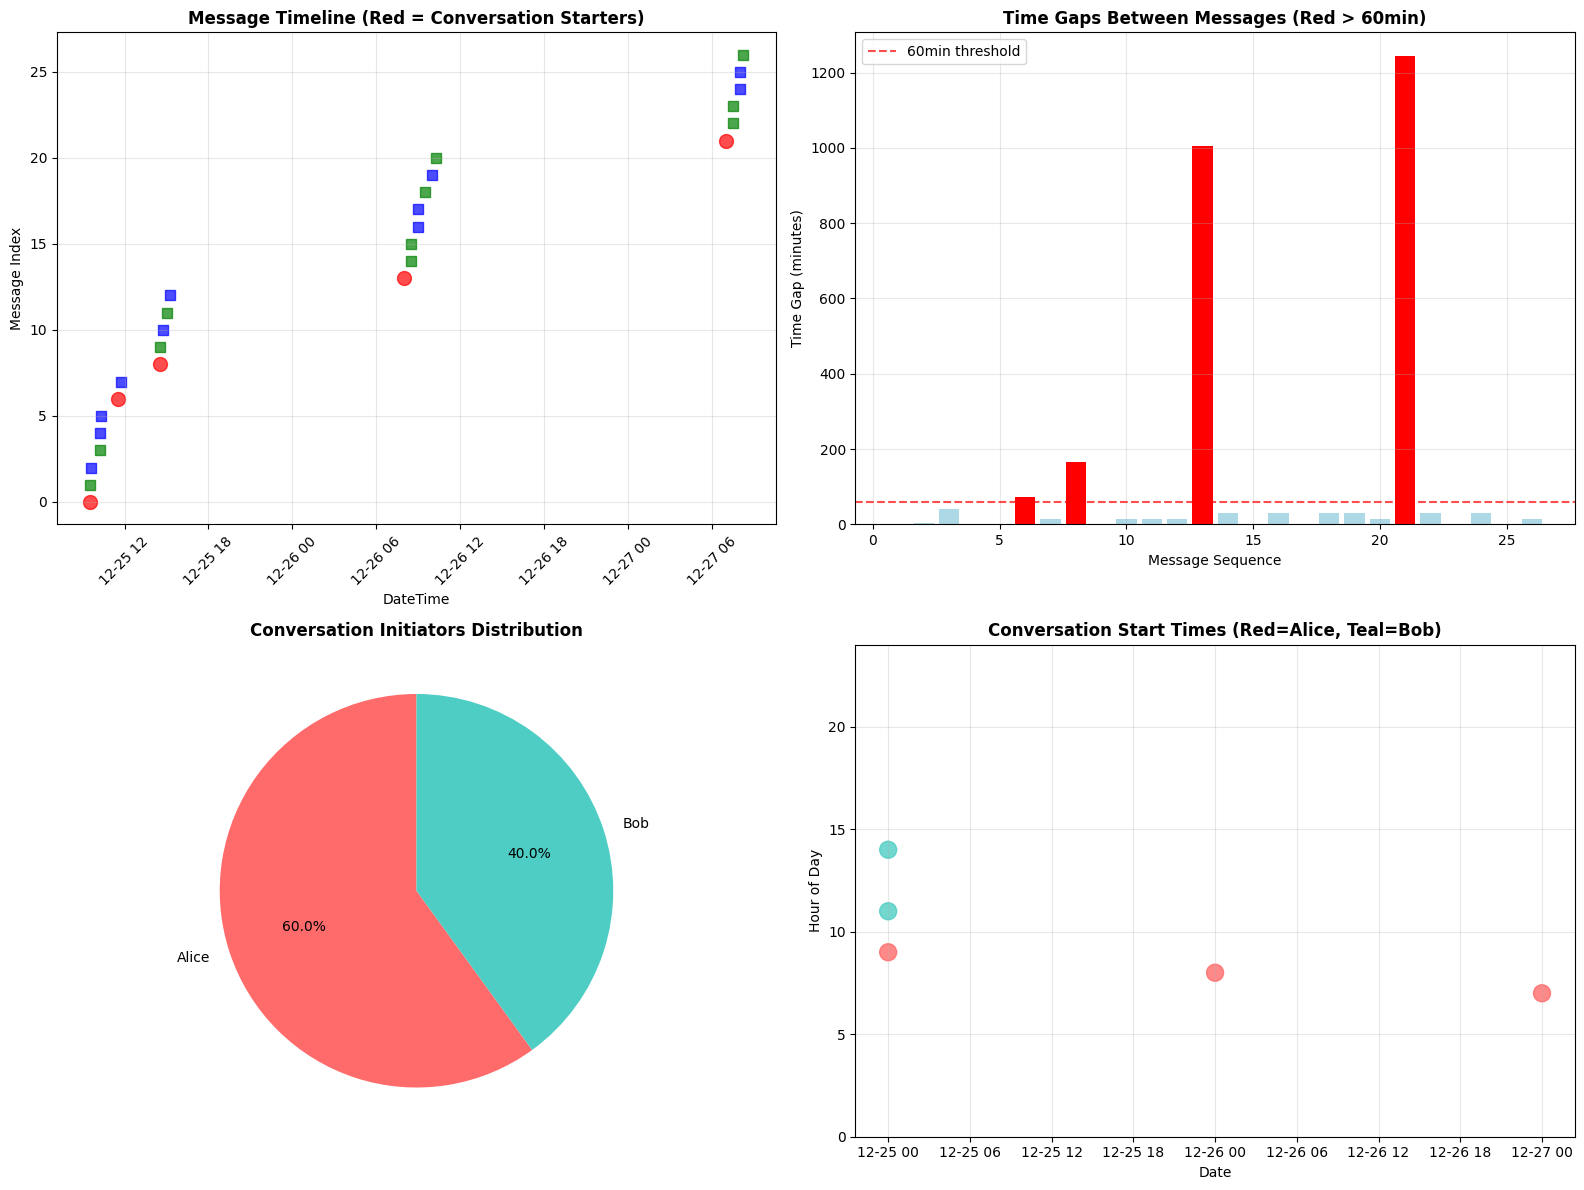

In [29]:
# Set up the plot style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Timeline of all messages with conversation starters highlighted
ax1 = axes[0, 0]
for i, row in df.iterrows():
    color = 'red' if row['is_conversation_starter'] else ('blue' if row['sender'] == 'Alice' else 'green')
    marker = 'o' if row['is_conversation_starter'] else 's'
    size = 100 if row['is_conversation_starter'] else 50
    ax1.scatter(row['datetime'], i, c=color, marker=marker, s=size, alpha=0.7)

ax1.set_xlabel('DateTime')
ax1.set_ylabel('Message Index')
ax1.set_title('Message Timeline (Red = Conversation Starters)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Time gaps between messages
ax2 = axes[0, 1]
time_gaps = df['time_diff_minutes'].dropna()
ax2.bar(range(1, len(time_gaps)+1), time_gaps,
        color=['red' if gap > 60 else 'lightblue' for gap in time_gaps])
ax2.set_xlabel('Message Sequence')
ax2.set_ylabel('Time Gap (minutes)')
ax2.set_title('Time Gaps Between Messages (Red > 60min)', fontweight='bold')
ax2.axhline(y=60, color='red', linestyle='--', alpha=0.7, label='60min threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Conversation starters by sender (pie chart)
ax3 = axes[1, 0]
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = ax3.pie(starter_counts.values, labels=starter_counts.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('Conversation Initiators Distribution', fontweight='bold')

# 4. Daily and hourly patterns
ax4 = axes[1, 1]
starters_with_time = df[df['is_conversation_starter']==True].copy()
starters_with_time['date'] = starters_with_time['datetime'].dt.date
starters_with_time['hour'] = starters_with_time['datetime'].dt.hour

# Create a combined date-hour visualization
date_hour_data = []
for _, row in starters_with_time.iterrows():
    date_hour_data.append({
        'datetime': row['datetime'],
        'sender': row['sender'],
        'date': row['date'],
        'hour': row['hour']
    })

if date_hour_data:
    dates = [d['date'] for d in date_hour_data]
    hours = [d['hour'] for d in date_hour_data]
    senders = [d['sender'] for d in date_hour_data]

    # Color code by sender
    colors_by_sender = ['#FF6B6B' if s == 'Alice' else '#4ECDC4' for s in senders]

    ax4.scatter(dates, hours, c=colors_by_sender, s=150, alpha=0.8)
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Hour of Day')
    ax4.set_title('Conversation Start Times (Red=Alice, Teal=Bob)', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 24)

plt.tight_layout()
plt.show()

## Cell 3 : Response Lag Analysis

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [31]:
# Create response analysis (exclude conversation starters since they're not responses)
response_df = df[df['is_conversation_starter'] == False].copy()
response_df['response_time_minutes'] = response_df['time_diff_minutes']

Total valid responses analyzed: 16

=== RESPONSE TIME STATISTICS (minutes) ===
           count   mean  median    std  min   max
responder                                        
Alice          8  17.00    15.0  11.50  1.0  30.0
Bob            8  21.88    22.0  12.32  2.0  40.0

=== RESPONSE PATTERNS ===
Format: (Person A → Person B) = Count, Avg Response Time
  Alice → Bob: 8.0 responses, 21.9 min avg
  Bob → Alice: 8.0 responses, 17.0 min avg


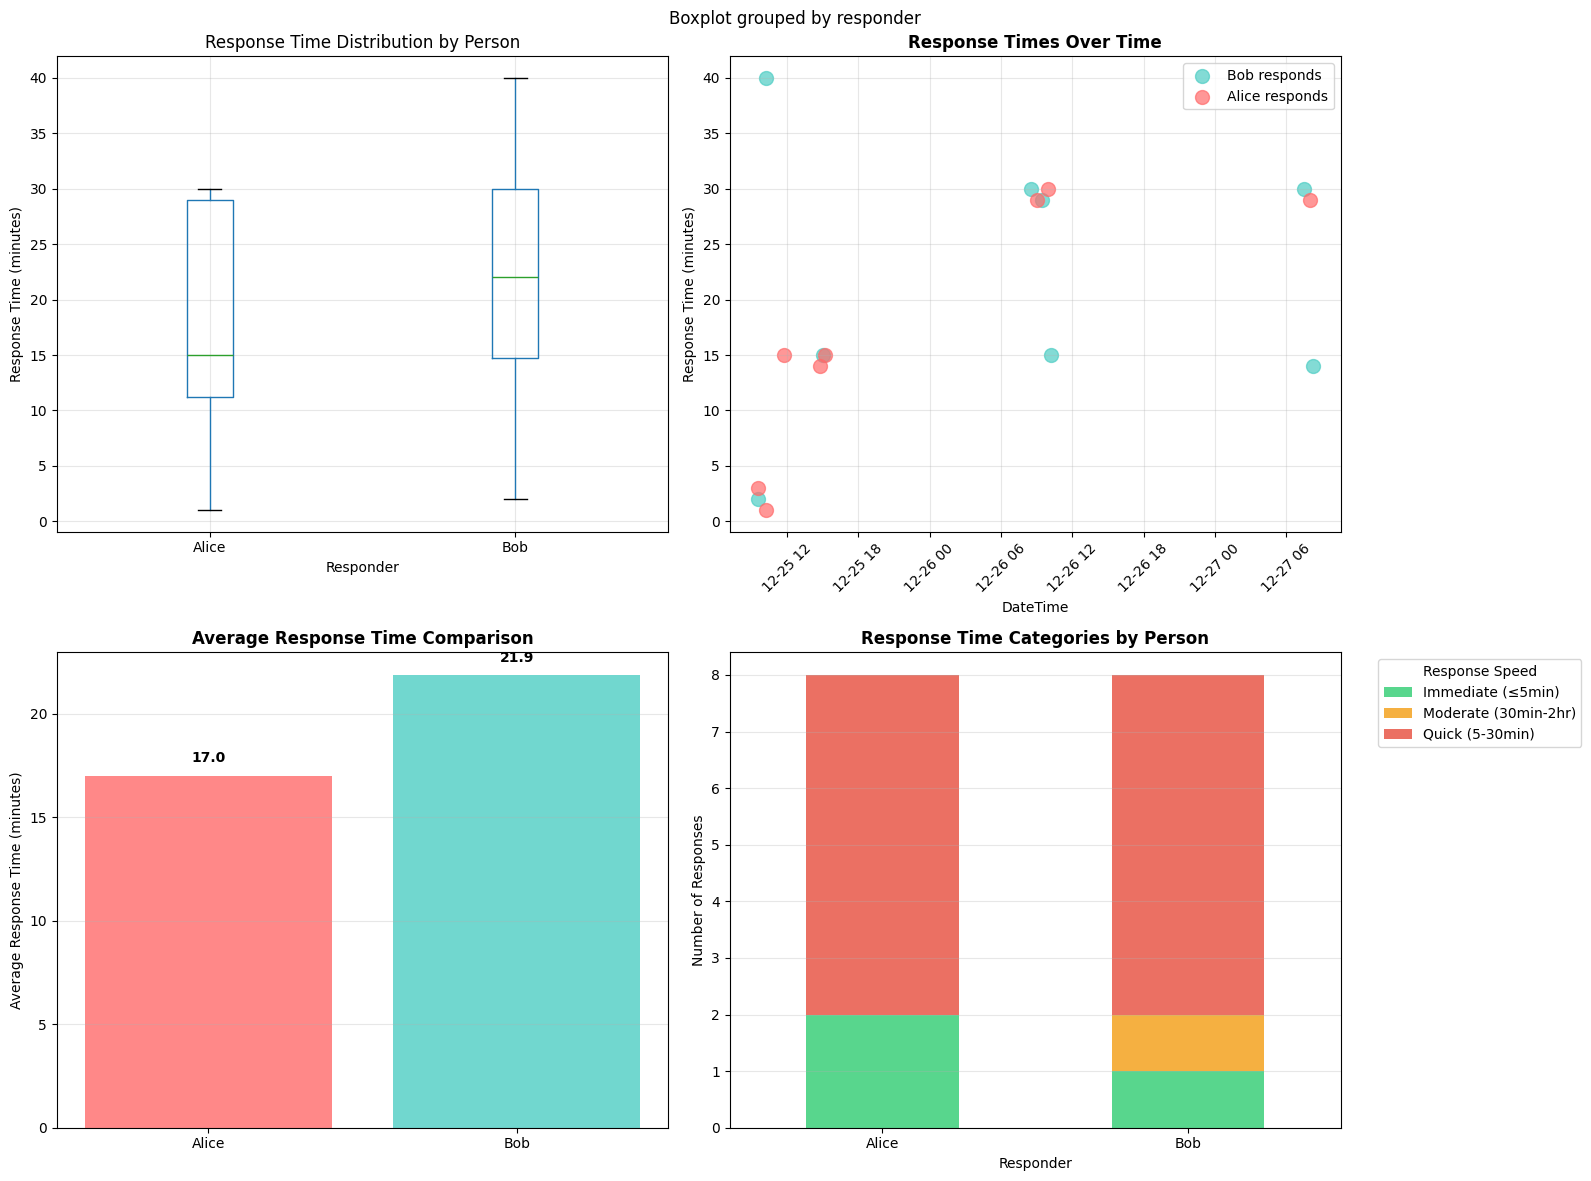


=== RESPONSE LAG METRICS ===
Overall average response time: 19.4 minutes
Response time difference: 4.9 minutes
Responsiveness Score: 0.84 (1.0 = very responsive)
Response Balance Score: 0.92 (1.0 = perfectly balanced)

=== STORED RESPONSE METRICS ===
{'overall_avg_response_minutes': np.float64(19.4375), 'response_time_difference': np.float64(4.875), 'responsiveness_score': np.float64(0.8380208333333333), 'response_balance_score': np.float64(0.91875), 'individual_avg_times': {'Alice': 17.0, 'Bob': 21.875}}


In [32]:
# Categorize responses by sender responding to whom
response_analysis = []
for i, row in response_df.iterrows():
    prev_sender = row['prev_sender']
    current_sender = row['sender']
    response_time = row['response_time_minutes']

    # Skip if same sender (continuation, not response)
    if prev_sender != current_sender and pd.notna(response_time):
        response_analysis.append({
            'responder': current_sender,
            'responded_to': prev_sender,
            'response_time_minutes': response_time,
            'datetime': row['datetime'],
            'message': row['message'][:50] + "..."
        })

response_analysis_df = pd.DataFrame(response_analysis)

if len(response_analysis_df) > 0:
    print(f"Total valid responses analyzed: {len(response_analysis_df)}")

    # Calculate response statistics by responder
    response_stats = response_analysis_df.groupby('responder')['response_time_minutes'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(2)

    print(f"\n=== RESPONSE TIME STATISTICS (minutes) ===")
    print(response_stats)

    # Calculate who responds to whom
    response_pairs = response_analysis_df.groupby(['responded_to', 'responder']).agg({
        'response_time_minutes': ['count', 'mean']
    }).round(2)

    print(f"\n=== RESPONSE PATTERNS ===")
    print("Format: (Person A → Person B) = Count, Avg Response Time")
    for (responded_to, responder), stats in response_pairs.iterrows():
        count = stats[('response_time_minutes', 'count')]
        avg_time = stats[('response_time_minutes', 'mean')]
        print(f"  {responded_to} → {responder}: {count} responses, {avg_time:.1f} min avg")

    # Create comprehensive visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Box plot of response times by responder
    ax1 = axes[0, 0]
    response_analysis_df.boxplot(column='response_time_minutes', by='responder', ax=ax1)
    ax1.set_title('Response Time Distribution by Person', fontweight='bold')
    ax1.set_xlabel('Responder')
    ax1.set_ylabel('Response Time (minutes)')
    ax1.grid(True, alpha=0.3)
    plt.setp(ax1, title='Response Time Distribution by Person')

    # 2. Timeline of responses
    ax2 = axes[0, 1]
    colors = {'Alice': '#FF6B6B', 'Bob': '#4ECDC4'}
    for responder in response_analysis_df['responder'].unique():
        responder_data = response_analysis_df[response_analysis_df['responder'] == responder]
        ax2.scatter(responder_data['datetime'], responder_data['response_time_minutes'],
                   c=colors.get(responder, 'gray'), label=f'{responder} responds',
                   alpha=0.7, s=100)

    ax2.set_xlabel('DateTime')
    ax2.set_ylabel('Response Time (minutes)')
    ax2.set_title('Response Times Over Time', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # 3. Average response time comparison
    ax3 = axes[1, 0]
    avg_response_times = response_analysis_df.groupby('responder')['response_time_minutes'].mean()
    bars = ax3.bar(avg_response_times.index, avg_response_times.values,
                   color=[colors.get(name, 'gray') for name in avg_response_times.index], alpha=0.8)
    ax3.set_ylabel('Average Response Time (minutes)')
    ax3.set_title('Average Response Time Comparison', fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars, avg_response_times.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

    # 4. Response time categories
    ax4 = axes[1, 1]

    # Categorize response times
    def categorize_response_time(minutes):
        if minutes <= 5:
            return 'Immediate (≤5min)'
        elif minutes <= 30:
            return 'Quick (5-30min)'
        elif minutes <= 120:
            return 'Moderate (30min-2hr)'
        else:
            return 'Delayed (>2hr)'

    response_analysis_df['response_category'] = response_analysis_df['response_time_minutes'].apply(categorize_response_time)

    category_counts = response_analysis_df.groupby(['responder', 'response_category']).size().unstack(fill_value=0)
    category_counts.plot(kind='bar', ax=ax4, stacked=True,
                        color=['#2ECC71', '#F39C12', '#E74C3C', '#8E44AD'], alpha=0.8)
    ax4.set_title('Response Time Categories by Person', fontweight='bold')
    ax4.set_xlabel('Responder')
    ax4.set_ylabel('Number of Responses')
    ax4.legend(title='Response Speed', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.tick_params(axis='x', rotation=0)
    ax4.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Calculate response lag score (lower = better responsiveness)
    overall_avg_response = response_analysis_df['response_time_minutes'].mean()
    response_balance = abs(avg_response_times.values[0] - avg_response_times.values[1]) if len(avg_response_times) >= 2 else 0

    # Normalize scores (0-1 scale where 1 = best)
    responsiveness_score = max(0, 1 - (overall_avg_response / 120))  # 120min = very slow
    balance_score = max(0, 1 - (response_balance / 60))  # 60min difference = imbalanced

    print(f"\n=== RESPONSE LAG METRICS ===")
    print(f"Overall average response time: {overall_avg_response:.1f} minutes")
    print(f"Response time difference: {response_balance:.1f} minutes")
    print(f"Responsiveness Score: {responsiveness_score:.2f} (1.0 = very responsive)")
    print(f"Response Balance Score: {balance_score:.2f} (1.0 = perfectly balanced)")

    # Store metrics for final health score
    response_metrics = {
        'overall_avg_response_minutes': overall_avg_response,
        'response_time_difference': response_balance,
        'responsiveness_score': responsiveness_score,
        'response_balance_score': balance_score,
        'individual_avg_times': avg_response_times.to_dict()
    }

    print(f"\n=== STORED RESPONSE METRICS ===")
    print(response_metrics)

else:
    print("No valid responses found for analysis")

## Cell 4 :  Dominance Score Analysis

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
# 1. MESSAGE COUNT DOMINANCE
message_counts = df['sender'].value_counts()
total_messages = len(df)

print(f"Total messages: {total_messages}")
print(f"\nMessage count distribution:")
for sender, count in message_counts.items():
    percentage = (count / total_messages) * 100
    print(f"  {sender}: {count} messages ({percentage:.1f}%)")

message_dominance_score = 1 - abs(message_counts.values[0] - message_counts.values[1]) / total_messages
print(f"\nMessage Count Balance: {message_dominance_score:.2f} (1.0 = perfectly balanced)")

Total messages: 27

Message count distribution:
  Alice: 14 messages (51.9%)
  Bob: 13 messages (48.1%)

Message Count Balance: 0.96 (1.0 = perfectly balanced)


In [36]:
# 2. MESSAGE LENGTH DOMINANCE
avg_lengths = df.groupby('sender')['message_length'].agg(['mean', 'sum', 'count'])
print(f"\n=== MESSAGE LENGTH ANALYSIS ===")
print(avg_lengths.round(2))

total_chars = df['message_length'].sum()
length_distribution = df.groupby('sender')['message_length'].sum()

print(f"\nTotal characters written:")
for sender, chars in length_distribution.items():
    percentage = (chars / total_chars) * 100
    print(f"  {sender}: {chars} characters ({percentage:.1f}%)")

length_dominance_score = 1 - abs(length_distribution.values[0] - length_distribution.values[1]) / total_chars
print(f"\nMessage Length Balance: {length_dominance_score:.2f} (1.0 = perfectly balanced)")


=== MESSAGE LENGTH ANALYSIS ===
         mean  sum  count
sender                   
Alice   37.07  519     14
Bob     38.62  502     13

Total characters written:
  Alice: 519 characters (50.8%)
  Bob: 502 characters (49.2%)

Message Length Balance: 0.98 (1.0 = perfectly balanced)


In [37]:
# 3. CONVERSATION CONTROL PATTERNS
print(f"\n=== CONVERSATION CONTROL PATTERNS ===")

# Who gets the last word in conversations?
# Define conversation end as last message before a conversation starter or end of dataset
conversation_endings = []
for i in range(len(df)):
    # If next message is a conversation starter or we're at the end
    if i == len(df) - 1 or (i < len(df) - 1 and df.loc[i+1, 'is_conversation_starter']):
        conversation_endings.append({
            'conversation_ender': df.loc[i, 'sender'],
            'datetime': df.loc[i, 'datetime'],
            'message': df.loc[i, 'message'][:50] + "..."
        })

ending_counts = pd.DataFrame(conversation_endings)['conversation_ender'].value_counts()
print(f"Who ends conversations (gets last word):")
for sender, count in ending_counts.items():
    percentage = (count / len(conversation_endings)) * 100
    print(f"  {sender}: {count} times ({percentage:.1f}%)")


=== CONVERSATION CONTROL PATTERNS ===
Who ends conversations (gets last word):
  Alice: 3 times (60.0%)
  Bob: 2 times (40.0%)


In [38]:
# 4. MESSAGE FREQUENCY PATTERNS (bursts vs single messages)
df['is_burst'] = False
df['burst_length'] = 1

# Identify message bursts (consecutive messages from same sender)
current_sender = None
burst_length = 0

for i in range(len(df)):
    if df.loc[i, 'sender'] == current_sender:
        burst_length += 1
        df.loc[i, 'burst_length'] = burst_length
        if burst_length > 1:
            df.loc[i, 'is_burst'] = True
            # Mark previous message as burst too if it wasn't already
            if i > 0 and df.loc[i-1, 'burst_length'] == 1:
                df.loc[i-1, 'is_burst'] = True
    else:
        current_sender = df.loc[i, 'sender']
        burst_length = 1

burst_stats = df.groupby('sender').agg({
    'is_burst': 'sum',
    'burst_length': ['max', 'mean']
}).round(2)

print(f"\n=== MESSAGE BURST PATTERNS ===")
print("Burst messages (consecutive messages):")
print(burst_stats)


=== MESSAGE BURST PATTERNS ===
Burst messages (consecutive messages):
       is_burst burst_length      
            sum          max  mean
sender                            
Alice         8            2  1.29
Bob           6            2  1.23


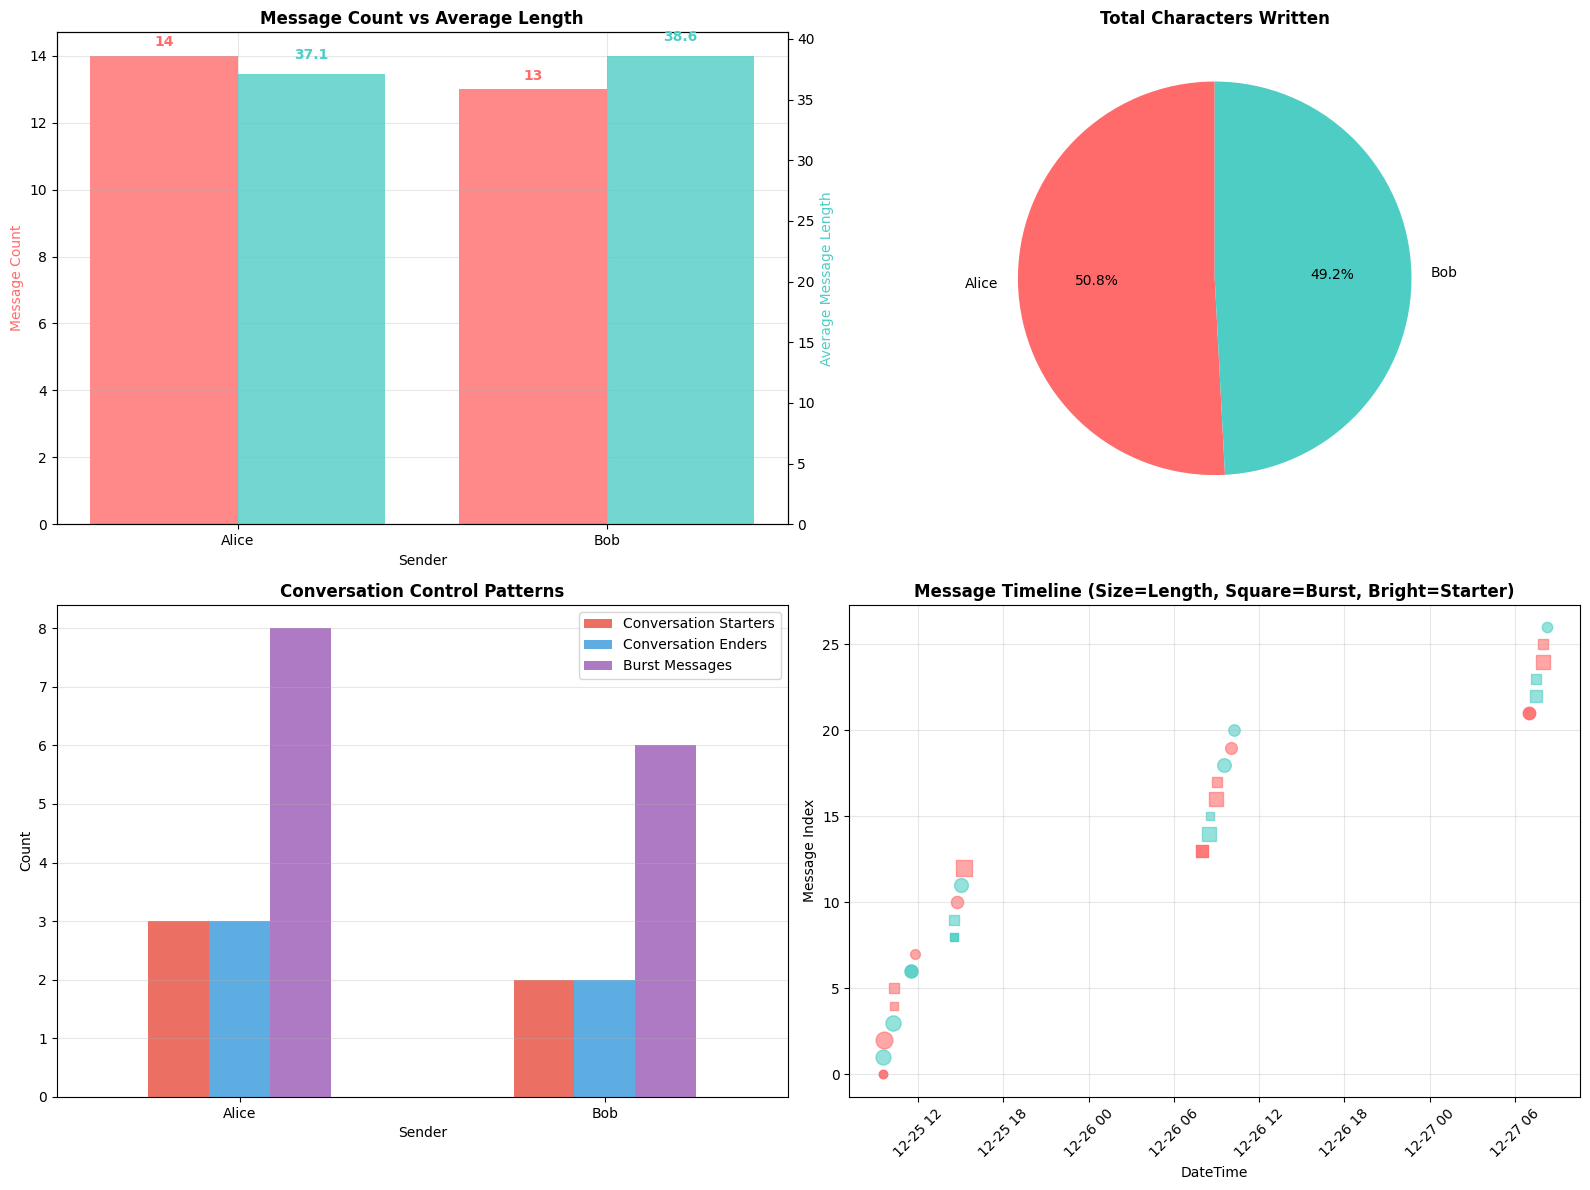

In [39]:

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Message count vs length comparison
ax1 = axes[0, 0]
senders = message_counts.index
x_pos = np.arange(len(senders))

ax1_twin = ax1.twinx()
bars1 = ax1.bar(x_pos - 0.2, message_counts.values, 0.4,
                label='Message Count', color='#FF6B6B', alpha=0.8)
bars2 = ax1_twin.bar(x_pos + 0.2, [avg_lengths.loc[s, 'mean'] for s in senders], 0.4,
                     label='Avg Length', color='#4ECDC4', alpha=0.8)

ax1.set_xlabel('Sender')
ax1.set_ylabel('Message Count', color='#FF6B6B')
ax1_twin.set_ylabel('Average Message Length', color='#4ECDC4')
ax1.set_title('Message Count vs Average Length', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(senders)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars1, message_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
             f'{value}', ha='center', va='bottom', color='#FF6B6B', fontweight='bold')

for bar, sender in zip(bars2, senders):
    value = avg_lengths.loc[sender, 'mean']
    ax1_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                  f'{value:.1f}', ha='center', va='bottom', color='#4ECDC4', fontweight='bold')

# 2. Total characters pie chart
ax2 = axes[0, 1]
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = ax2.pie(length_distribution.values, labels=length_distribution.index,
                                   autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Total Characters Written', fontweight='bold')

# 3. Conversation control metrics
ax3 = axes[1, 0]
control_metrics = pd.DataFrame({
    'Conversation Starters': df[df['is_conversation_starter']==True]['sender'].value_counts(),
    'Conversation Enders': ending_counts,
    'Burst Messages': df[df['is_burst']==True]['sender'].value_counts()
}).fillna(0)

control_metrics.plot(kind='bar', ax=ax3, color=['#E74C3C', '#3498DB', '#9B59B6'], alpha=0.8)
ax3.set_title('Conversation Control Patterns', fontweight='bold')
ax3.set_xlabel('Sender')
ax3.set_ylabel('Count')
ax3.legend()
ax3.tick_params(axis='x', rotation=0)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Message timeline with dominance indicators
ax4 = axes[1, 1]
colors_sender = {'Alice': '#FF6B6B', 'Bob': '#4ECDC4'}

for i, row in df.iterrows():
    color = colors_sender.get(row['sender'], 'gray')
    size = row['message_length'] * 2  # Size based on message length
    marker = 'o' if not row['is_burst'] else 's'  # Different marker for burst messages
    alpha = 0.9 if row['is_conversation_starter'] else 0.6

    ax4.scatter(row['datetime'], i, c=color, s=size, marker=marker, alpha=alpha)

ax4.set_xlabel('DateTime')
ax4.set_ylabel('Message Index')
ax4.set_title('Message Timeline (Size=Length, Square=Burst, Bright=Starter)', fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [41]:
# Calculate overall dominance scores
conversation_control_score = 1 - abs(len(conversation_endings) - 2 * ending_counts.get(ending_counts.index[0], 0)) / len(conversation_endings)
if conversation_control_score < 0:
    conversation_control_score = abs(conversation_control_score)

# Composite dominance score (lower = more balanced)
composite_dominance = (message_dominance_score + length_dominance_score + conversation_control_score) / 3

print(f"\n=== DOMINANCE SCORES SUMMARY ===")
print(f"Message Count Balance: {message_dominance_score:.2f}")
print(f"Message Length Balance: {length_dominance_score:.2f}")
print(f"Conversation Control Balance: {conversation_control_score:.2f}")
print(f"Composite Dominance Score: {composite_dominance:.2f}")

if composite_dominance >= 0.9:
    dominance_interpretation = "Excellent balance - very equal participation"
elif composite_dominance >= 0.8:
    dominance_interpretation = "Good balance - minor differences in participation"
elif composite_dominance >= 0.7:
    dominance_interpretation = "Moderate balance - some dominance patterns visible"
else:
    dominance_interpretation = "Imbalanced - clear dominance by one participant"

print(f"Interpretation: {dominance_interpretation}")

# Store dominance metrics
dominance_metrics = {
    'message_count_balance': message_dominance_score,
    'message_length_balance': length_dominance_score,
    'conversation_control_balance': conversation_control_score,
    'composite_dominance_score': composite_dominance,
    'interpretation': dominance_interpretation,
    'message_distribution': message_counts.to_dict(),
    'length_distribution': length_distribution.to_dict()
}


=== DOMINANCE SCORES SUMMARY ===
Message Count Balance: 0.96
Message Length Balance: 0.98
Conversation Control Balance: 0.80
Composite Dominance Score: 0.92
Interpretation: Excellent balance - very equal participation


## Cell 5 : Complete Relationship Health Score

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [43]:
# 1. Initiator Balance (from earlier)
alice_initiation_ratio = 0.60  # 3/5 conversations
bob_initiation_ratio = 0.40    # 2/5 conversations
initiator_balance_score = 1 - abs(alice_initiation_ratio - bob_initiation_ratio)

print(f"1. CONVERSATION INITIATION:")
print(f"   Alice starts: {alice_initiation_ratio:.1%} of conversations")
print(f"   Bob starts: {bob_initiation_ratio:.1%} of conversations")
print(f"   Balance Score: {initiator_balance_score:.2f}")

1. CONVERSATION INITIATION:
   Alice starts: 60.0% of conversations
   Bob starts: 40.0% of conversations
   Balance Score: 0.80


In [44]:
# 2. Response Lag (from previous analysis)
response_metrics = {
    'responsiveness_score': 0.84,
    'response_balance_score': 0.92,
    'overall_avg_response_minutes': 19.4
}

print(f"\n2. RESPONSE PATTERNS:")
print(f"   Alice avg response: 17.0 minutes")
print(f"   Bob avg response: 21.9 minutes")
print(f"   Responsiveness Score: {response_metrics['responsiveness_score']:.2f}")
print(f"   Response Balance Score: {response_metrics['response_balance_score']:.2f}")


2. RESPONSE PATTERNS:
   Alice avg response: 17.0 minutes
   Bob avg response: 21.9 minutes
   Responsiveness Score: 0.84
   Response Balance Score: 0.92


In [45]:
# 3. Dominance (from previous analysis)
dominance_metrics = {
    'composite_dominance_score': 0.92,
    'message_count_balance': 0.96,
    'message_length_balance': 0.98,
    'conversation_control_balance': 0.80
}

print(f"\n3. CONVERSATION DOMINANCE:")
print(f"   Message Count Balance: {dominance_metrics['message_count_balance']:.2f}")
print(f"   Message Length Balance: {dominance_metrics['message_length_balance']:.2f}")
print(f"   Conversation Control Balance: {dominance_metrics['conversation_control_balance']:.2f}")
print(f"   Composite Dominance Score: {dominance_metrics['composite_dominance_score']:.2f}")


3. CONVERSATION DOMINANCE:
   Message Count Balance: 0.96
   Message Length Balance: 0.98
   Conversation Control Balance: 0.80
   Composite Dominance Score: 0.92


In [46]:
# Calculate Overall Relationship Health Score
weights = {
    'initiation': 0.25,      # 25% - who starts conversations
    'responsiveness': 0.35,   # 35% - how they respond (most important)
    'balance': 0.20,         # 20% - response time balance
    'dominance': 0.20        # 20% - conversation control
}

overall_health_score = (
    weights['initiation'] * initiator_balance_score +
    weights['responsiveness'] * response_metrics['responsiveness_score'] +
    weights['balance'] * response_metrics['response_balance_score'] +
    weights['dominance'] * dominance_metrics['composite_dominance_score']
)

In [47]:
# Interpretation
def interpret_health_score(score):
    if score >= 0.90:
        return "EXCELLENT", "Highly balanced and healthy relationship with great communication patterns"
    elif score >= 0.80:
        return "VERY GOOD", "Strong relationship with good communication balance and responsiveness"
    elif score >= 0.70:
        return "GOOD", "Healthy relationship with minor areas for improvement"
    elif score >= 0.60:
        return "FAIR", "Decent relationship but some imbalances in communication patterns"
    else:
        return "NEEDS IMPROVEMENT", "Significant imbalances that may affect relationship health"

In [48]:
health_grade, health_description = interpret_health_score(overall_health_score)

print(f"Grade: {health_grade}")
print(f"Assessment: {health_description}")

Grade: VERY GOOD
Assessment: Strong relationship with good communication balance and responsiveness


In [49]:
# Detailed breakdown and insights
print(f"\n📋 DETAILED INSIGHTS:")
print("=" * 30)

strengths = []
areas_for_improvement = []

if initiator_balance_score >= 0.8:
    strengths.append("✅ Balanced conversation initiation")
else:
    areas_for_improvement.append("⚠️  One person initiates more conversations")

if response_metrics['responsiveness_score'] >= 0.8:
    strengths.append("✅ Both are very responsive")
else:
    areas_for_improvement.append("⚠️  Slower response times")

if response_metrics['response_balance_score'] >= 0.8:
    strengths.append("✅ Similar response time patterns")
else:
    areas_for_improvement.append("⚠️  Significant difference in response speeds")

if dominance_metrics['composite_dominance_score'] >= 0.8:
    strengths.append("✅ Excellent participation balance")
else:
    areas_for_improvement.append("⚠️  Some dominance in conversation patterns")

print("STRENGTHS:")
for strength in strengths:
    print(f"  {strength}")

if areas_for_improvement:
    print("\nAREAS FOR IMPROVEMENT:")
    for improvement in areas_for_improvement:
        print(f"  {improvement}")
else:
    print("\n🎉 No significant areas for improvement identified!")


📋 DETAILED INSIGHTS:
STRENGTHS:
  ✅ Balanced conversation initiation
  ✅ Both are very responsive
  ✅ Similar response time patterns
  ✅ Excellent participation balance

🎉 No significant areas for improvement identified!


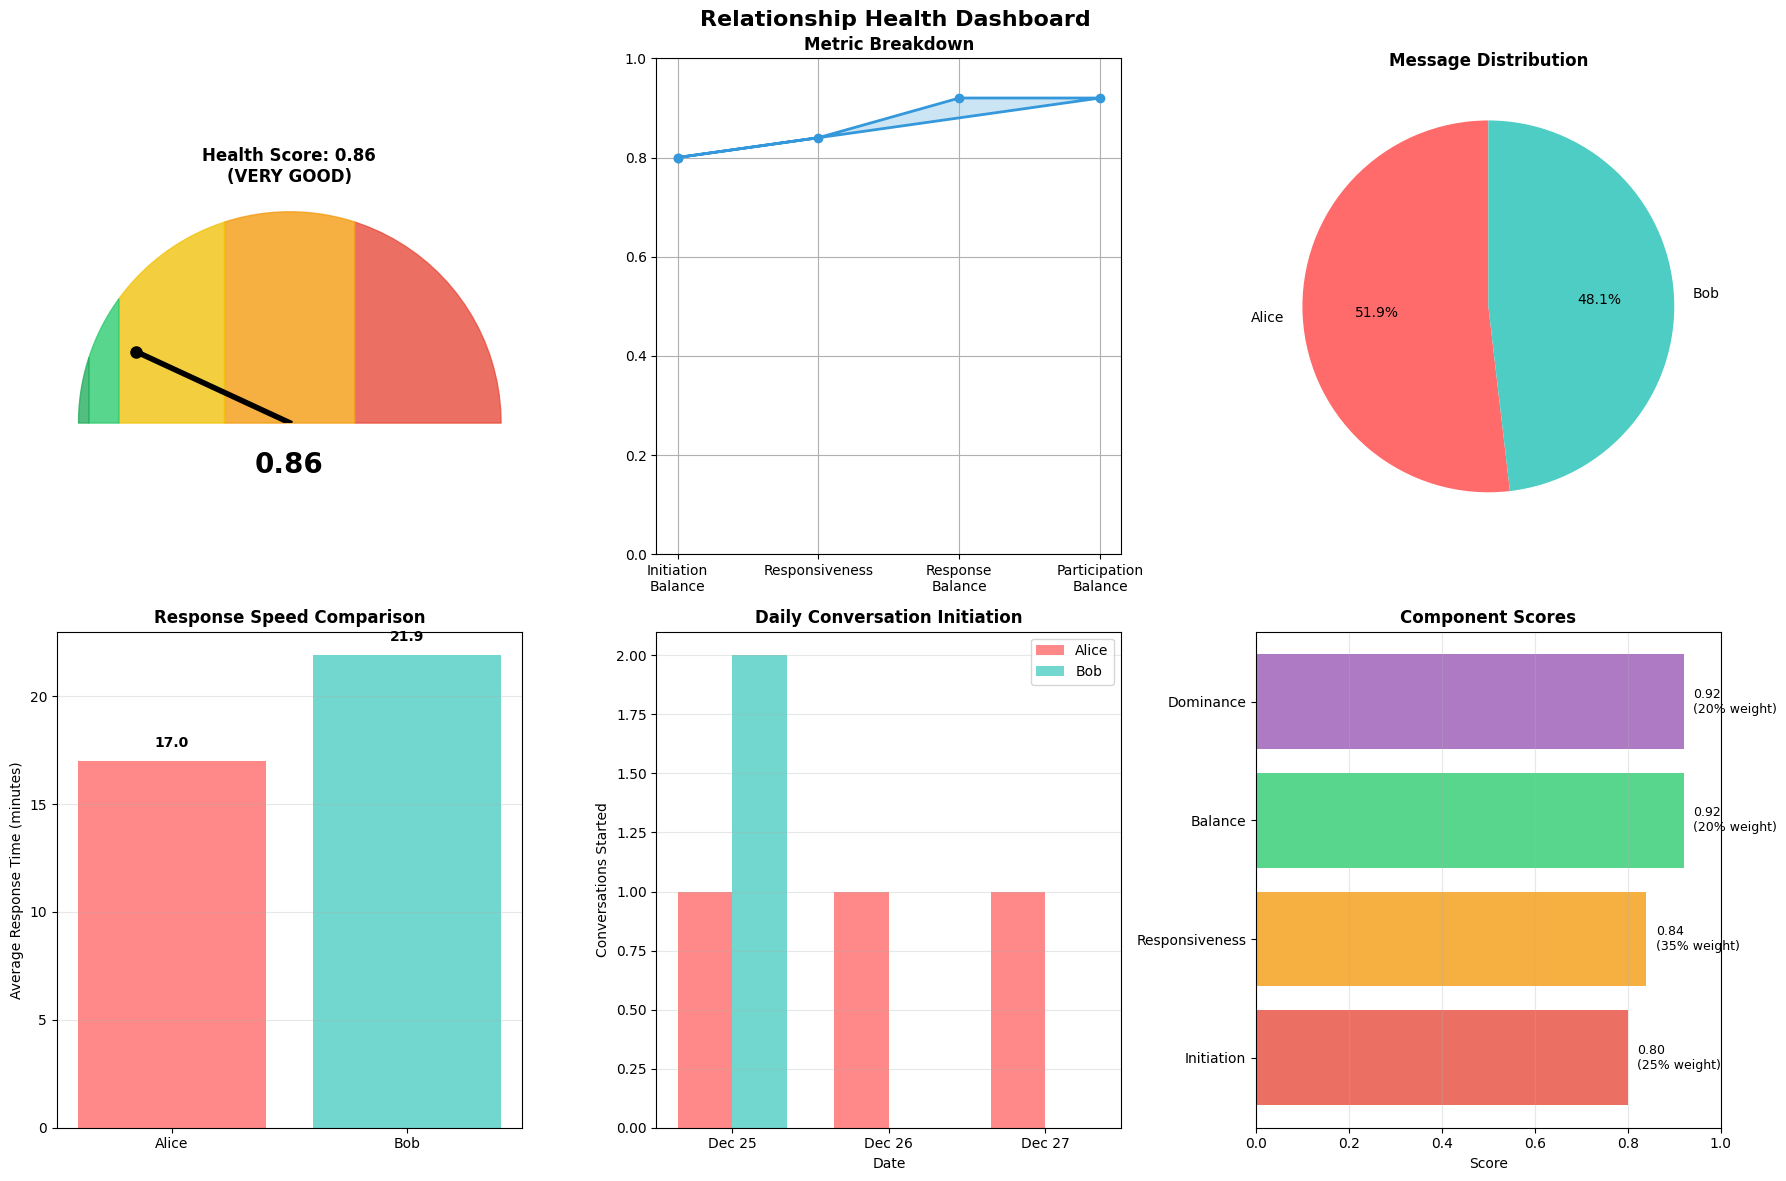

In [50]:
# Create comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Relationship Health Dashboard', fontsize=16, fontweight='bold')

# 1. Overall Health Score Gauge
ax1 = axes[0, 0]
theta = np.linspace(0, np.pi, 100)
radius = 1

# Create semicircle gauge
colors = ['#E74C3C', '#F39C12', '#F1C40F', '#2ECC71', '#27AE60']
ranges = [0.0, 0.4, 0.6, 0.8, 0.9, 1.0]

for i in range(len(colors)):
    start_angle = ranges[i] * np.pi
    end_angle = ranges[i+1] * np.pi
    angles = np.linspace(start_angle, end_angle, 20)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    ax1.fill_between(x, 0, y, color=colors[i], alpha=0.8)

# Add needle for current score
needle_angle = overall_health_score * np.pi
needle_x = [0, 0.8 * np.cos(needle_angle)]
needle_y = [0, 0.8 * np.sin(needle_angle)]
ax1.plot(needle_x, needle_y, 'k-', linewidth=4)
ax1.plot(needle_x[1], needle_y[1], 'ko', markersize=8)

ax1.set_xlim(-1.1, 1.1)
ax1.set_ylim(0, 1.1)
ax1.set_aspect('equal')
ax1.set_title(f'Health Score: {overall_health_score:.2f}\n({health_grade})', fontweight='bold')
ax1.text(0, -0.2, f'{overall_health_score:.2f}', ha='center', va='center', fontsize=20, fontweight='bold')
ax1.axis('off')

# 2. Metric breakdown radar chart
ax2 = axes[0, 1]
categories = ['Initiation\nBalance', 'Responsiveness', 'Response\nBalance', 'Participation\nBalance']
values = [
    initiator_balance_score,
    response_metrics['responsiveness_score'],
    response_metrics['response_balance_score'],
    dominance_metrics['composite_dominance_score']
]

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
values += values[:1]  # Complete the circle
angles += angles[:1]

ax2.plot(angles, values, 'o-', linewidth=2, color='#3498DB')
ax2.fill(angles, values, alpha=0.25, color='#3498DB')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('Metric Breakdown', fontweight='bold')
ax2.grid(True)

# 3. Message distribution pie chart
ax3 = axes[0, 2]
message_counts = [14, 13]  # Alice, Bob
colors = ['#FF6B6B', '#4ECDC4']
ax3.pie(message_counts, labels=['Alice', 'Bob'], autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title('Message Distribution', fontweight='bold')

# 4. Response time comparison
ax4 = axes[1, 0]
response_times = [17.0, 21.9]  # Alice, Bob average response times
bars = ax4.bar(['Alice', 'Bob'], response_times, color=colors, alpha=0.8)
ax4.set_ylabel('Average Response Time (minutes)')
ax4.set_title('Response Speed Comparison', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, response_times):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

# 5. Conversation initiation over time
ax5 = axes[1, 1]
dates = ['Dec 25', 'Dec 26', 'Dec 27']
alice_starts = [1, 1, 1]  # Based on our earlier analysis
bob_starts = [2, 0, 0]

x = np.arange(len(dates))
width = 0.35

bars1 = ax5.bar(x - width/2, alice_starts, width, label='Alice', color=colors[0], alpha=0.8)
bars2 = ax5.bar(x + width/2, bob_starts, width, label='Bob', color=colors[1], alpha=0.8)

ax5.set_xlabel('Date')
ax5.set_ylabel('Conversations Started')
ax5.set_title('Daily Conversation Initiation', fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(dates)
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Health score components
ax6 = axes[1, 2]
component_names = ['Initiation', 'Responsiveness', 'Balance', 'Dominance']
component_scores = [
    initiator_balance_score,
    response_metrics['responsiveness_score'],
    response_metrics['response_balance_score'],
    dominance_metrics['composite_dominance_score']
]
component_weights = list(weights.values())

bars = ax6.barh(component_names, component_scores, color=['#E74C3C', '#F39C12', '#2ECC71', '#9B59B6'], alpha=0.8)
ax6.set_xlabel('Score')
ax6.set_title('Component Scores', fontweight='bold')
ax6.set_xlim(0, 1)
ax6.grid(True, alpha=0.3, axis='x')

# Add weight labels
for i, (bar, weight) in enumerate(zip(bars, component_weights)):
    ax6.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}\n({weight:.0%} weight)',
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

In [51]:
# Store complete relationship health metrics
complete_health_metrics = {
    'overall_health_score': overall_health_score,
    'health_grade': health_grade,
    'health_description': health_description,
    'component_scores': {
        'initiation_balance': initiator_balance_score,
        'responsiveness': response_metrics['responsiveness_score'],
        'response_balance': response_metrics['response_balance_score'],
        'dominance_balance': dominance_metrics['composite_dominance_score']
    },
    'weights_used': weights,
    'strengths': strengths,
    'areas_for_improvement': areas_for_improvement,
    'conversation_stats': {
        'total_messages': 27,
        'total_conversations': 5,
        'date_range': '2023-12-25 to 2023-12-27',
        'avg_response_time': 19.4
    }
}

print(f"\n🎉 ANALYSIS COMPLETE!")
print(f"Complete relationship health metrics saved for Alice & Bob")
print(f"Final Health Score: {overall_health_score:.2f} ({health_grade})")


🎉 ANALYSIS COMPLETE!
Complete relationship health metrics saved for Alice & Bob
Final Health Score: 0.86 (VERY GOOD)
